# ライブラリのインポート / データの読み込み

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

%matplotlib inline

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick # For specifying the axes tick format 

import seaborn as sns
import re

import json, os, gc, math, time
import datetime
import collections
from tqdm import tqdm
import glob

from statistics import mean
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

from sklearn import metrics

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [3]:
#ドライブへのアクセス
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/00_datascience/19_ufj_bank"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/00_datascience/19_ufj_bank


In [4]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
sub = pd.read_csv('input/sample_submit.csv')

In [5]:
train.head()

,id,goal,country,duration,category1,category2,html_content,state
0,train_00000,20001-21000,US,45,art,mixed media,"<div class=""contents""><div><p><a href=""http://dummy.com"">http://dummy.com<p>In its first year, The Shillito's Elves Display won an international \ndesign award for Shillito's department store. The elves display is arts\n and crafts at its finest. The mixed media exhibit displays the talents\n of local fine arts graduates, and the display, while ""folksy"", is as \ntechnologically advanced as Disney World's famous ""It's a Small World"" \nride. </p><p>The Shillito's Elves attracted close to 100...",1
1,train_00001,19001-20000,US,59,food,restaurants,"<div class=""contents""><div><p>Cultural Pretzel Sports Bar is a place where people can come and watch their favorite local and world wide sports teams, while enjoying their favorite ethnic foods on a soft pretzel. Our menu includes a variety of appetizers and soft pretzels. Our pretzels include - Mexican Taco, Mexican Steak Fajita, Greek Gyro, Italian Sausage and Peppers, and American Steak Philly Soft Pretzels. With more to be added to the menu as the business grows.</p><p>Cultural Pretze...",0
2,train_00002,2001-3000,US,38,art,performance art,"<div class=""contents""><div><p>I want to perform this piece guerilla style, off the back off a 24 Ft truck on Christmas Eve, amid last minute Christmas shopping in New York City.</p>\n<p>Our truck pulls in, the door rolls up and I perform. </p>\n<p>New York is a city where you just do it - no excuses. A place where the new becomes the normal real fast and where the artist is challenged to capture the attention and the hearts of the unshockable and unstoppable. In times of celebration and re...",0
3,train_00003,1001-2000,US,30,art,mixed media,"<div class=""contents""><div><div class=""template asset"" contenteditable=""false"" data-alt-text="""" data-caption="""" data-id=""_xxx_"">\n<figure>\n<img alt="""" class=""fit lazyload"" data-src=""http://dummy.com""/>\n</figure>\n</div>\n<h1 class=""page-anchor"" id=""_xxx_"">\n<figure>\n<img alt=""Canyon de Chelley, Dine' (Navajo) Reservation, Arizona. Photo by: Demian Dine' Yazhi'"" class=""fit lazyload"" data-src=""http://dummy.com""/>\n<figcaption class=""px2"">Canyon de Chelley, Dine' (Navajo) Reservation, Arizo...",1
4,train_00004,1001-2000,US,29,film & video,webseries,"<div class=""contents""><div><p>The story of the show, both on and off screen, is about daring to dream after something impossible.Even with an incredible amount of difficulty and opposition, the project continued to grow in size and depth. A year ago, we were finally able to release the pilot episode of Azusa Ghost Hunter's Society (check it out! <a href=""http://dummy.com"">\n<figure>\n<img alt="""" class=""fit lazyload"" data-src=""http://dummy.com""/>\n</figure>\n</div>\n<p>Which brings us to now...",1


# bertによる特徴抽出

In [6]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [7]:
for i in range(len(train)):
  train.loc[i, 'cleaned_text'] = remove_html(train.loc[i, 'html_content'])

for i in range(len(test)):
  test.loc[i, 'cleaned_text'] = remove_html(test.loc[i, 'html_content'])

In [8]:
import torch
import transformers

from transformers import BertTokenizer


class BertSequenceVectorizer:
    def __init__(self, model_name="bert-base-uncased", max_len=128):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = max_len

    def vectorize(self, sentence: str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [9]:
BSV = BertSequenceVectorizer(
    model_name="bert-base-multilingual-uncased",
    max_len=128)
features = np.stack(
    train["cleaned_text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values
)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through t

array([[ 0.15426822,  0.42690793, -0.6671073 , ...,  0.30919245,
        -0.23509827, -0.20304629],
       [-0.49318343, -0.04855378, -0.42514196, ...,  0.23457606,
        -0.4776769 , -0.11740218],
       [-0.48848012,  0.2700108 , -0.7089348 , ...,  0.48887953,
        -0.25549698, -0.28257903],
       ...,
       [-0.18412118,  0.11386099, -0.76075166, ...,  0.6602018 ,
         0.4074243 , -0.5289747 ],
       [-0.27763516, -0.03558884, -0.47346577, ...,  0.379366  ,
         0.05855879, -0.25395754],
       [-0.08669196,  0.14139496, -0.40012917, ...,  0.62337196,
         0.2827652 , -0.04988688]], dtype=float32)

In [10]:
text_train_df = pd.DataFrame(features)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0.154268,0.426908,-0.667107,-0.208326,-0.557405,0.373454,0.609862,-0.459978,-0.275123,1.208694,-0.897790,-0.314383,0.235323,-0.342225,0.145068,-0.681703,-0.355545,0.411888,-0.489604,-0.002067,-0.175616,-0.044353,-0.296066,-0.584157,0.348938,0.135271,-0.137074,0.226559,0.654229,0.346562,0.147058,-0.171390,-0.137678,0.162680,-0.290194,-0.281450,-0.181878,-0.620040,0.604024,-0.005003,0.155425,-0.132849,-0.799479,0.674082,-0.335961,0.194647,0.483408,0.165787,-0.406830,-0.059661,0.010121,0.238150,0.833479,-0.477464,0.524920,0.154898,0.173979,-0.368898,-0.259465,0.290243,-0.472785,0.107705,-0.350074,0.479970,-0.137800,0.372565,0.360008,0.917156,0.514113,0.356909,-0.112621,-0.597167,0.786024,0.485075,0.764594,-0.161696,-0.374799,0.289044,-0.251097,0.346851,0.265162,0.226724,0.790008,0.826052,-0.256264,0.290617,-0.662511,0.302461,0.086265,0.264238,1.045804,-0.833158,-0.694462,-0.269102,0.317376,0.378027,-0.542219,0.263983,0.157129,0.313637,0.034495,0.731502,0.032816,0.563870,0.128147,0.266157,-0.574664,-1.079259,0.418637,-1.004035,0.215033,0.336970,-0.167837,-0.872233,-0.265242,0.621456,0.013897,0.150116,-1.321607,-0.231782,-0.910497,-0.094036,-0.023384,-0.253461,0.130262,-0.306957,-0.505595,0.345254,0.115750,0.322503,0.317540,-0.033528,0.543350,-0.382351,-0.442437,-0.286574,0.942885,1.331304,0.123217,0.374633,-0.094339,-0.291156,0.465276,0.017435,0.109251,0.202373,1.260413,-0.133725,-0.902015,0.461430,0.787611,0.477499,0.421217,-1.313719,-0.945169,0.143732,-0.360298,0.386185,0.110628,-0.626568,-0.659054,0.206146,-0.612812,-0.356767,-0.445829,-1.638759,-0.625563,-0.025422,-0.247030,0.258975,0.851605,0.864835,0.656909,-0.699163,-0.404692,-0.441935,-1.255887,-0.276727,-0.433353,0.400382,-0.618375,1.075116,0.380817,0.651455,-0.250593,1.183498,-0.277090,-0.051416,0.307658,-0.008813,0.589340,-0.200592,0.181262,-0.254748,0.191886,-0.203280,0.388307,0.281139,0.628328,-0.409826,-0.290997,0.111203,0.451303,0.376484,0.197912,0.245877,-0.753265,0.221394,-0.192555,0.407504,0.518708,0.232957,-0.444881,0.392654,-0.793468,-0.449757,-0.569690,-0.566652,0.041139,-0.807330,0.079954,0.835305,-

In [11]:
BSV = BertSequenceVectorizer(
    model_name="bert-base-multilingual-uncased",
    max_len=128)
features_test = np.stack(
    test["cleaned_text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values
)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through t

array([[-0.0197574 ,  0.11717127, -0.19674172, ...,  0.38636732,
        -0.05791218, -0.70981807],
       [ 0.120088  ,  0.55567217, -0.49372345, ...,  0.70566154,
         0.36766893, -0.39456508],
       [ 0.02878513,  0.65699315, -0.5757143 , ...,  0.6649788 ,
         0.18269141,  0.02293321],
       ...,
       [ 0.00839435,  0.00749181,  0.0639539 , ...,  0.01553946,
        -0.01724813,  0.03202715],
       [ 0.21356125,  0.53529274, -0.6185485 , ...,  0.5385918 ,
         0.19501758,  0.1031575 ],
       [-0.23945314, -0.27283135, -0.19986665, ...,  0.46365353,
         0.21864645, -0.07891037]], dtype=float32)

In [12]:
text_test_df = pd.DataFrame(features_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.019757,0.117171,-0.196742,-0.212951,-0.453174,0.536196,0.795506,-1.103634,-0.150393,0.673334,-0.704563,0.363245,-0.243029,-0.144285,0.528918,0.138478,0.265337,0.038448,-0.556983,-0.657685,-0.481509,-0.063652,-0.059811,-0.787461,-0.342277,0.987384,0.272132,0.294322,0.350371,-0.125979,0.320733,0.421869,0.432771,-0.002750,-0.394265,-0.428559,-0.793418,-0.018272,-0.021596,0.698569,-0.305856,0.118797,-0.262287,0.248590,-0.341960,-0.106704,0.312415,-0.132384,-0.455024,0.299932,-0.744779,-0.034362,0.129694,-0.273622,0.431249,0.510345,0.374077,-0.452395,-0.144005,0.089194,-0.515654,-0.014333,-0.650817,0.037207,-0.292517,1.000335,0.198447,0.454168,0.461509,0.527245,0.239225,-0.360876,0.397764,-0.201942,0.327398,0.097504,0.186387,0.248952,0.255819,0.664824,0.203927,-0.095707,0.028951,1.124423,0.535091,0.720941,-0.824681,-0.022632,0.144756,0.558823,1.131336,-0.810040,-0.771192,0.052421,0.200882,0.571572,-0.992747,-0.657041,0.443441,0.175831,0.199236,-0.334878,-0.437296,-0.213385,0.202523,0.766962,-0.970548,-0.642676,0.193803,-0.646354,0.212040,0.318278,-0.265122,-0.287482,-0.592958,0.517816,-0.220788,-0.118870,-0.827380,-0.449966,-0.565507,-0.229361,-0.528925,-0.735849,-0.459112,-0.745650,-0.475847,0.769341,0.948208,0.160543,-0.135515,-0.244355,-0.137470,0.457532,-0.450052,-0.287068,0.576382,0.749483,-0.314772,0.345160,0.511307,0.107627,0.307967,0.504365,-0.382318,0.141861,0.733213,-0.446408,-0.676643,0.258811,0.838511,-0.119235,0.041055,-1.525860,-0.561398,0.051552,-0.264052,0.384060,-0.090487,-0.709100,-0.993913,0.184043,-0.362813,-0.524662,-0.126444,-0.870793,-0.526907,0.167067,-0.060991,-0.131652,0.563384,0.992946,0.316913,-0.931671,-0.467560,0.074269,-0.842734,-0.003215,-0.309246,0.762130,-0.614284,0.421107,-0.078856,0.461736,-0.335030,0.735035,-0.732058,0.475759,-0.010947,-0.068314,-0.058392,-0.369611,0.214420,0.194482,0.428835,-0.016415,0.532317,1.177962,0.829328,-0.219591,-0.347208,0.205857,0.198115,-0.234233,0.482806,0.081083,-0.370675,0.225779,-0.482074,0.467698,0.478725,0.504888,-0.717668,0.062314,-0.008596,-0.775926,0.421821,-1.122043,-0.087584,-0.747615,-0.78087

In [28]:
merge_text = pd.concat([text_train_df, text_test_df], ignore_index=True)

# ラベルデータの前処理

In [14]:
# ワンホットエンコーディング
merge_df = pd.concat([train, test], ignore_index=True)
dummy_cols = ['goal',	'country', 'category1',	'category2']
from sklearn.preprocessing import OneHotEncoder

dummy_df = pd.get_dummies(merge_df[dummy_cols])

In [16]:
merge_df_new = pd.merge(merge_df, dummy_df, left_index=True, right_index=True)
#merge_df_new = pd.merge(merge_df_new, dummy_df, left_index=True, right_index=True)

# tfidfによる特徴抽出

In [21]:
#tfidfによる特徴抽出
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer()
features = tv.fit_transform(merge_df_new["cleaned_text"].fillna(""))

In [25]:
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.pipeline import Pipeline



tfidf_svd = Pipeline(steps=[
    ("TfidfVectorizer", TfidfVectorizer()),
    ("TruncatedSVD", TruncatedSVD(n_components=50, random_state=42))
])

features_svd = tfidf_svd.fit_transform(merge_df_new["cleaned_text"].fillna(""))

array([[ 0.29497459,  0.00061151,  0.0230934 , ..., -0.01883829,
        -0.03189132, -0.00586705],
       [ 0.16320261, -0.00391595,  0.02725234, ..., -0.00223386,
         0.00084604, -0.02656226],
       [ 0.41671094,  0.00467784, -0.05210802, ..., -0.02442564,
        -0.0041136 , -0.06999428],
       ...,
       [ 0.02691047,  0.01123956,  0.00228326, ..., -0.01008772,
        -0.01377093, -0.00847392],
       [ 0.52180631, -0.00073743,  0.02636572, ...,  0.01115816,
        -0.02912113,  0.05947524],
       [ 0.4210727 , -0.01853777,  0.23362451, ..., -0.00354951,
         0.0115819 , -0.0485232 ]])

In [27]:
svd_df_merge = pd.DataFrame(features_svd)
svd_df_merge.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.294975,0.000612,0.023093,-0.043301,-0.004649,0.020541,-0.045337,0.023749,-0.013550,0.034197,-0.013022,0.006791,-0.034909,0.006838,-0.015130,0.005652,-0.006562,0.028293,0.020380,-0.021149,0.014203,0.012766,-0.021624,0.008557,-0.033513,0.021839,-0.029243,0.018258,0.040335,0.013609,0.009730,-0.025807,-0.011607,-0.016283,-0.001402,-0.008286,0.003465,-0.027083,-0.020888,-0.006050,0.025245,0.050684,0.018035,-0.003444,-0.016337,-0.011634,-0.045625,-0.018838,-0.031891,-0.005867
1,0.163203,-0.003916,0.027252,0.018163,-0.002540,-0.027746,0.007868,0.058626,-0.076375,0.005537,0.001517,0.063067,0.065023,-0.036968,0.008155,-0.003813,0.084616,-0.047082,-0.007784,-0.024780,-0.022541,0.037703,0.000743,-0.016317,0.020467,-0.004459,0.013540,-0.020566,-0.011280,-0.014888,-0.022607,0.005381,0.006592,0.031154,-0.001644,-0.021823,0.001153,-0.012336,0.011720,0.024251,0.008138,-0.020235,0.012740,0.010774,0.020248,-0.006551,-0.008633,-0.002234,0.000846,-0.026562
2,0.416711,0.004678,-0.052108,-0.079082,-0.010638,0.082929,-0.018381,0.036628,-0.071629,-0.046454,-0.014980,0.041316,-0.020198,-0.010975,-0.087276,-0.007349,-0.030171,0.014232,-0.013043,-0.046913,-0.023943,0.036428,0.027846,-0.033865,-0.007355,-0.006390,0.046919,-0.010758,0.026100,-0.038122,-0.011840,0.023103,0.024219,-0.019092,0.007193,-0.044791,-0.015232,-0.034269,0.004956,0.011575,-0.000471,0.000399,0.030256,-0.018961,-0.024183,0.009083,0.049905,-0.024426,-0.004114,-0.069994
3,0.354831,0.040357,-0.074435,-0.139759,-0.016492,0.005695,-0.074024,-0.054700,-0.033431,0.030271,0.012615,-0.062605,0.008202,-0.000162,-0.032588,-0.007491,-0.049390,0.035334,-0.013804,-0.028062,0.019617,-0.020532,0.060234,-0.026357,-0.016961,-0.027071,0.033834,-0.005823,-0.077913,0.026541,0.035371,-0.021575,0.007319,0.010192,-0.005169,0.009147,0.007499,0.017499,0.003257,0.016648,-0.031395,-0.018403,0.033881,0.000654,-0.004903,-0.000448,0.007058,-0.027521,0.001671,-0.018905
4,0.260418,0.001437,0.023826,-0.039866,-0.012193,0.048334,0.003215,0.018024,0.000459,0.010460,-0.007537,0.005912,-0.013804,-0.001257,0.006475,-0.006275,-0.013372,-0.004754,-0.011707,0.004615,-0.020253,0.022072,-0.038320,-0.031949,0.021487,-0.045155,0.025808,0.028343,-0.050307,-0.025407,-0.003430,0.009133,0.003049,-0.006112,0.014727,-0.010559,-0.001788,-0.021023,-0.015821,-0.001193,-0.018419,0.000753,0.000358,0.005429,0.016303,0.036587,0.004850,-0.007258,0.013238,-0.015719


# データのマージ/kmeans用の前処理

In [30]:
#不要なカラムの定義
non_use_cols = ['id',	'goal',	'country',	'category1', 'category2',	'html_content',	'cleaned_text', 'state']

In [32]:
#bertから抽出した特徴量を追加
full_merge_df = pd.merge(merge_df_new.drop(non_use_cols, axis=1), merge_text, left_index=True, right_index=True)

In [36]:
#tfidfから抽出した特徴量を追加
full_merge_df_fin = pd.merge(full_merge_df, svd_df_merge, left_index=True, right_index=True)

In [37]:
full_merge_df_fin.head()

,duration,goal_1-1000_x,goal_100000+_x,goal_10001-11000_x,goal_1001-2000_x,goal_11001-12000_x,goal_12001-13000_x,goal_13001-14000_x,goal_14001-15000_x,goal_15001-16000_x,goal_16001-17000_x,goal_17001-18000_x,goal_18001-19000_x,goal_19001-20000_x,goal_20001-21000_x,goal_2001-3000_x,goal_21001-22000_x,goal_22001-23000_x,goal_23001-24000_x,goal_24001-25000_x,goal_25001-26000_x,goal_26001-27000_x,goal_27001-28000_x,goal_28001-29000_x,goal_29001-30000_x,goal_30001-31000_x,goal_3001-4000_x,goal_31001-32000_x,goal_32001-33000_x,goal_33001-34000_x,goal_34001-35000_x,goal_35001-36000_x,goal_36001-37000_x,goal_37001-38000_x,goal_38001-39000_x,goal_39001-40000_x,goal_40001-41000_x,goal_4001-5000_x,goal_41001-42000_x,goal_42001-43000_x,goal_43001-44000_x,goal_44001-45000_x,goal_45001-46000_x,goal_46001-47000_x,goal_47001-48000_x,goal_48001-49000_x,goal_49001-50000_x,goal_50001-51000_x,goal_5001-6000_x,goal_51001-52000_x,goal_52001-53000_x,goal_53001-54000_x,goal_54001-55000_x,goal_55001-56000_x,goal_56001-57000_x,goal_57001-58000_x,goal_58001-59000_x,goal_59001-60000_x,goal_60001-61000_x,goal_6001-7000_x,goal_61001-62000_x,goal_62001-63000_x,goal_63001-64000_x,goal_64001-65000_x,goal_65001-66000_x,goal_66001-67000_x,goal_67001-68000_x,goal_68001-69000_x,goal_69001-70000_x,goal_70001-71000_x,goal_7001-8000_x,goal_71001-72000_x,goal_72001-73000_x,goal_73001-74000_x,goal_74001-75000_x,goal_75001-76000_x,goal_76001-77000_x,goal_77001-78000_x,goal_78001-79000_x,goal_79001-80000_x,goal_80001-81000_x,goal_8001-9000_x,goal_81001-82000_x,goal_82001-83000_x,goal_83001-84000_x,goal_84001-85000_x,goal_85001-86000_x,goal_86001-87000_x,goal_87001-88000_x,goal_88001-89000_x,goal_89001-90000_x,goal_90001-91000_x,goal_9001-10000_x,goal_91001-92000_x,goal_92001-93000_x,goal_93001-94000_x,goal_94001-95000_x,goal_95001-96000_x,goal_96001-97000_x,goal_97001-98000_x,goal_98001-99000_x,goal_99001-100000_x,country_AT_x,country_AU_x,country_BE_x,country_CA_x,country_CH_x,country_DE_x,country_DK_x,country_ES_x,country_FR_x,country_GB_x,country_HK_x,country_IE_x,country_IT_x,country_JP_x,country_LU_x,country_MX_x,country_NL_x,country_NO_x,country_NZ_x,country_SE_x,country_SG_x,country_US_x,category1_art_x,category1_comics_x,category1_crafts_x,category1_dance_x,category1_design_x,category1_fashion_x,category1_film & video_x,category1_food_x,category1_games_x,category1_journalism_x,category1_music_x,category1_photography_x,category1_publishing_x,category1_technology_x,category1_theater_x,category2_3d printing_x,category2_academic_x,category2_accessories_x,category2_action_x,category2_animals_x,category2_animation_x,category2_anthologies_x,category2_apparel_x,category2_apps_x,category2_architecture_x,category2_art books_x,category2_audio_x,category2_bacon_x,category2_blues_x,category2_calendars_x,category2_camera equipment_x,category2_candles_x,category2_ceramics_x,category2_children's books_x,category2_childrenswear_x,category2_chiptune_x,category2_civic design_x,category2_classical music_x,category2_comedy_x,category2_comic books_x,category2_community gardens_x,category2_conceptual art_x,category2_cookbooks_x,category2_country & folk_x,category2_couture_x,category2_crochet_x,category2_digital art_x,category2_diy_x,category2_diy electronics_x,category2_documentary_x,category2_drama_x,category2_drinks_x,category2_electronic music_x,category2_embroidery_x,category2_events_x,category2_experimental_x,category2_fabrication tools_x,category2_faith_x,category2_family_x,category2_fantasy_x,category2_farmer's markets_x,category2_farms_x,category2_festivals_x,category2_fiction_x,category2_fine art_x,category2_flight_x,category2_food trucks_x,category2_footwear_x,category2_gadgets_x,category2_gaming hardware_x,category2_glass_x,category2_graphic design_x,category2_graphic novels_x,category2_hardware_x,category2_hip-hop_x,category2_horror_x,category2_illustration_x,category2_immersive_x,category2_indie rock_x,category2_installations_x,category2_interactive design_x,category2_jaz

In [47]:
#durationのスケーリング
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
full_merge_df_fin['duration'] = std.fit_transform(pd.DataFrame(full_merge_df_fin['duration']))

# kmeansによるクラスタリング

Text(0, 0.5, 'Distortion')

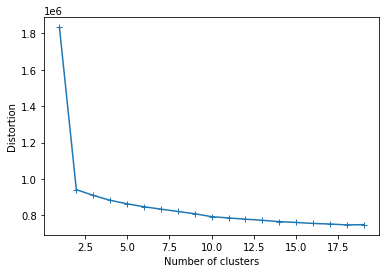

In [54]:
# エルボー方による推定。クラスター数を1から20に増やして、それぞれの距離の総和を求める
from sklearn.cluster import KMeans
dist_list =[]
for i in range(1,20):
    kmeans= KMeans(n_clusters=i, init='random', random_state=0)
    kmeans.fit(full_merge_df_fin)
    dist_list.append(kmeans.inertia_)
    
# グラフを表示
plt.plot(range(1,20), dist_list,marker='+')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

In [57]:
# n_clusters=2と10で実験

kmeans = KMeans(init='random', n_clusters=2, random_state=0)
kmeans.fit(full_merge_df_fin)
km_label_df2 =pd.Series(kmeans.labels_, name='cluster_number_{}'.format(2))

kmeans = KMeans(init='random', n_clusters=2, random_state=0)
kmeans.fit(full_merge_df_fin)
km_label_df10 =pd.Series(kmeans.labels_, name='cluster_number_{}'.format(2))

In [58]:
#マージ
full_merge_df_fin['cluster_number_2'] = km_label_df2
full_merge_df_fin['cluster_number_10'] = km_label_df10

# データセットの整理

In [61]:
train_df = pd.DataFrame(full_merge_df_fin.loc[:len(train),])
test_df = pd.DataFrame(full_merge_df_fin.loc[len(train):19591,])

In [62]:
test_df = test_df.reset_index()
test_df.drop(['index'], axis=1, inplace=True)
test_df.head()

,duration,goal_1-1000_x,goal_100000+_x,goal_10001-11000_x,goal_1001-2000_x,goal_11001-12000_x,goal_12001-13000_x,goal_13001-14000_x,goal_14001-15000_x,goal_15001-16000_x,goal_16001-17000_x,goal_17001-18000_x,goal_18001-19000_x,goal_19001-20000_x,goal_20001-21000_x,goal_2001-3000_x,goal_21001-22000_x,goal_22001-23000_x,goal_23001-24000_x,goal_24001-25000_x,goal_25001-26000_x,goal_26001-27000_x,goal_27001-28000_x,goal_28001-29000_x,goal_29001-30000_x,goal_30001-31000_x,goal_3001-4000_x,goal_31001-32000_x,goal_32001-33000_x,goal_33001-34000_x,goal_34001-35000_x,goal_35001-36000_x,goal_36001-37000_x,goal_37001-38000_x,goal_38001-39000_x,goal_39001-40000_x,goal_40001-41000_x,goal_4001-5000_x,goal_41001-42000_x,goal_42001-43000_x,goal_43001-44000_x,goal_44001-45000_x,goal_45001-46000_x,goal_46001-47000_x,goal_47001-48000_x,goal_48001-49000_x,goal_49001-50000_x,goal_50001-51000_x,goal_5001-6000_x,goal_51001-52000_x,goal_52001-53000_x,goal_53001-54000_x,goal_54001-55000_x,goal_55001-56000_x,goal_56001-57000_x,goal_57001-58000_x,goal_58001-59000_x,goal_59001-60000_x,goal_60001-61000_x,goal_6001-7000_x,goal_61001-62000_x,goal_62001-63000_x,goal_63001-64000_x,goal_64001-65000_x,goal_65001-66000_x,goal_66001-67000_x,goal_67001-68000_x,goal_68001-69000_x,goal_69001-70000_x,goal_70001-71000_x,goal_7001-8000_x,goal_71001-72000_x,goal_72001-73000_x,goal_73001-74000_x,goal_74001-75000_x,goal_75001-76000_x,goal_76001-77000_x,goal_77001-78000_x,goal_78001-79000_x,goal_79001-80000_x,goal_80001-81000_x,goal_8001-9000_x,goal_81001-82000_x,goal_82001-83000_x,goal_83001-84000_x,goal_84001-85000_x,goal_85001-86000_x,goal_86001-87000_x,goal_87001-88000_x,goal_88001-89000_x,goal_89001-90000_x,goal_90001-91000_x,goal_9001-10000_x,goal_91001-92000_x,goal_92001-93000_x,goal_93001-94000_x,goal_94001-95000_x,goal_95001-96000_x,goal_96001-97000_x,goal_97001-98000_x,goal_98001-99000_x,goal_99001-100000_x,country_AT_x,country_AU_x,country_BE_x,country_CA_x,country_CH_x,country_DE_x,country_DK_x,country_ES_x,country_FR_x,country_GB_x,country_HK_x,country_IE_x,country_IT_x,country_JP_x,country_LU_x,country_MX_x,country_NL_x,country_NO_x,country_NZ_x,country_SE_x,country_SG_x,country_US_x,category1_art_x,category1_comics_x,category1_crafts_x,category1_dance_x,category1_design_x,category1_fashion_x,category1_film & video_x,category1_food_x,category1_games_x,category1_journalism_x,category1_music_x,category1_photography_x,category1_publishing_x,category1_technology_x,category1_theater_x,category2_3d printing_x,category2_academic_x,category2_accessories_x,category2_action_x,category2_animals_x,category2_animation_x,category2_anthologies_x,category2_apparel_x,category2_apps_x,category2_architecture_x,category2_art books_x,category2_audio_x,category2_bacon_x,category2_blues_x,category2_calendars_x,category2_camera equipment_x,category2_candles_x,category2_ceramics_x,category2_children's books_x,category2_childrenswear_x,category2_chiptune_x,category2_civic design_x,category2_classical music_x,category2_comedy_x,category2_comic books_x,category2_community gardens_x,category2_conceptual art_x,category2_cookbooks_x,category2_country & folk_x,category2_couture_x,category2_crochet_x,category2_digital art_x,category2_diy_x,category2_diy electronics_x,category2_documentary_x,category2_drama_x,category2_drinks_x,category2_electronic music_x,category2_embroidery_x,category2_events_x,category2_experimental_x,category2_fabrication tools_x,category2_faith_x,category2_family_x,category2_fantasy_x,category2_farmer's markets_x,category2_farms_x,category2_festivals_x,category2_fiction_x,category2_fine art_x,category2_flight_x,category2_food trucks_x,category2_footwear_x,category2_gadgets_x,category2_gaming hardware_x,category2_glass_x,category2_graphic design_x,category2_graphic novels_x,category2_hardware_x,category2_hip-hop_x,category2_horror_x,category2_illustration_x,category2_immersive_x,category2_indie rock_x,category2_installations_x,category2_interactive design_x,category2_jaz

# lgbによる予測

In [63]:
target = train['state']

In [75]:
# 3分割交差検証を指定し、インスタンス化
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kf = KFold(n_splits=5)  # 3分割交差検証のためにインスタンス化

# スコアとモデルを格納するリスト
score_list = []
models = []

for fold_, (train_index, valid_index) in enumerate(kf.split(train, target)):
    train_x = train_df.iloc[train_index]
    valid_x = train_df.iloc[valid_index]
    train_y = target[train_index]
    valid_y = target[valid_index]
    
    print(f'fold{fold_ + 1} start')

    gbm = lgb.LGBMClassifier(objective='binary',num_boost_round=50000)
    gbm.fit(train_x, train_y, eval_set = [(valid_x, valid_y)],
                early_stopping_rounds=100,
                verbose= 100) # 学習の状況を表示しない
    
    oof = gbm.predict(valid_x, num_iteration=gbm.best_iteration_)
    score_list.append(round(accuracy_score(valid_y, oof)*100,2))
    models.append(gbm)  # 学習が終わったモデルをリストに入れておく
    print(f'fold{fold_ + 1} end\n' )
print(score_list, '平均score', np.mean(score_list), "%")  

fold1 start
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.454043
[200]	valid_0's binary_logloss: 0.452832
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.448002
fold1 end

fold2 start
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.479835
[200]	valid_0's binary_logloss: 0.481188
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.479017
fold2 end

fold3 start
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.464021
[200]	valid_0's binary_logloss: 0.469974
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.462251
fold3 end

fold4 start
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.436281
[200]	valid_0's binary_logloss: 0.43955
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.434087
fold4 end

fold5 start
Training unti

In [76]:
# testの予測
test_pred = np.zeros((len(test), 5))  # 行:len(test), 列:3のall zeroの配列を用意

for fold_, gbm in enumerate(models):  # 学習ずみのmodelをgbmに入れる
    pred_ = gbm.predict(test_df, num_iteration=gbm.best_iteration_)  # testの予測
    test_pred[:, fold_] = pred_  # １回目は0列目、2回目は1列目、2回目は3列目に格納

pred = (np.mean(test_pred, axis=1) > 0.5).astype(int)  # 平均をとって、0と１に変換

# submission

In [77]:
sub = pd.DataFrame(test['id'])

In [78]:
sub['state'] = pred
sub.head()

,id,state
0,test_00000,0
1,test_00001,1
2,test_00002,1
3,test_00003,0
4,test_00004,0


In [79]:
sub.to_csv('sub/03_baseline.csv',index=False, header=None)